# intro

The purpose of this notebook will be to create a concise, 5-subplot figure with:
- map overview (surface OHC trend, sea ice edge in March for certain averages, mark key gateways, overlay ocean currents
- time series, inflow evolotion (advective heat transport through the BSO, mean temperature of inflow, other gate specific transports)
- gate cross sections (4 small subplots of temperature profile at the gates; outline AW)
- N/S cross section in the interior (density evolution, emphasize AW shoaling, warming, upward mixing; outline AW)
- time series AW thickness time series over the Barents Sea interior along with sea ice extent (sea ice extent anomaly or labeled)

In [1]:
# import packages and functions

# import packages and functions
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from matplotlib.colors import ListedColormap, BoundaryNorm


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd  # For rolling mean
from scipy.ndimage import binary_dilation
from matplotlib.lines import Line2D

%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [4]:
# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

In [5]:
# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan
hfC[hfC<1] = np.nan

In [6]:
# define the gateways
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

x_nzru = np.full((5),37)
y_nzru = np.arange(460,465,1)

gates = np.full(mskBasin.shape,np.nan)
gates[y_bso,x_bso] = 1
gates[y_sfj,x_sfj] = 2
gates[y_fjnz,x_fjnz] = 3
gates[y_nzru,x_nzru] = 4

In [7]:
# also define the bear island trench
bso_depths = mygrid['Depth'][y_bso, x_bso]
valid_indices = bso_depths > 268

y_bit = y_bso[valid_indices]
x_bit = x_bso[valid_indices]
bit_mask = np.full(mskBasin.shape,np.nan)
bit_mask[y_bit,x_bit] = 1

In [8]:
# define the Barents Sea up to the NZRU opening
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan

In [9]:
# do some sample cross sections
y_sample = np.arange(435,551,1)
x_sample = np.full(y_sample.shape,466)

x_cross = np.arange(430,505,1)
y_cross = np.full(x_cross.shape,494)

sample_cross = np.full((900,540),np.nan)
sample_cross[y_sample,x_sample]= 1
sample_cross[y_cross,x_cross]= 3
sample_cross = aste_tracer2compact(sample_cross,nfx,nfy)[0]

(400.0, 600.0)

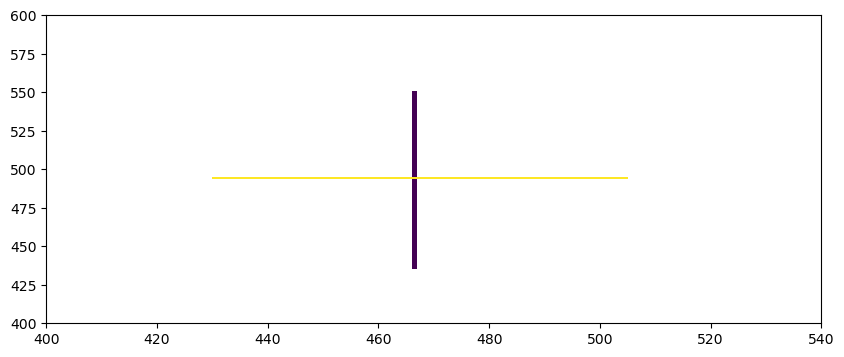

In [11]:
# plt.pcolormesh(land_data)
plt.pcolormesh(get_aste_tracer(sample_cross,nfx,nfy)[0])
plt.xlim(400,540)
plt.ylim(400,600)

# A: map overview

In [12]:
tstart = 3

In [13]:
lon = get_aste_tracer(mygrid['XC'],nfx,nfy)[0]
lat = get_aste_tracer(mygrid['YC'],nfx,nfy)[0]

In [26]:
# define the heat content
heat_content = np.full((len(allyears[tstart:]),12,ny,nx),np.nan)

# get the 
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name
dstart = 0
dterm = 10  # upper 100 m

# from Lind Paper
sref = 35
tref = 0

iy = 0
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETA = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    
        THETA[i,:,:,:] = np.reshape(THETAi,(nz,ny,nx)) / hfC   # degC

    ##########################################################################################
    # get the heat content
    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETA = THETA[i] #* mymsk[np.newaxis,:,:]    # degC
        thisheat = (thisTHETA - tref) * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * DRF3d  # J/m³ * m = J/m²

        # select heat based on the AW layer
        thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
        heat_content_2D = np.nansum(thisheat,axis=0)         # vertical integration (J/m^2)
        
        heat_content[iy,i,:,:] = heat_content_2D * 1e-6  # MJ/m^2

    #print()
    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [14]:
# define the sea ice extent for March

# we should also load the mean sea ice edge so we can plot this on bathymetry with the gates
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears[tstart:]),ny,nx))

iy = 0
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
  
    march_tsstr = tsstr[2]
    
    # read the fldList
    file_name = 'state_2d_set1'
    meta_state_2d_set1 = parsemeta(dirState + file_name + "." + march_tsstr + ".meta")
    fldlist = np.array(meta_state_2d_set1["fldList"])
    varnames = np.array(["SIarea"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])

    
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    read = int(tsstr[2])  # march
    SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
    SIarea = np.reshape(SIareai,(ny,nx))#*mymsk  # fraction of SIarea    
    SIareas[iy] = SIarea

    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [16]:
# define the velocities as an average
# define the path for UVEL and VVEL

dirtrsp = dirrun + "diags/TRSP/"

# read the files for velocity of upper 100m / bottom

# overlay on bathymetry
# make one set for DJFM and one set for JJAS
names_title = "Yearly"
months_i = np.arange(0,12,1)

all_UVEL_lower = np.zeros((len(allyears[tstart:]),len(months_i),900,540))
all_VVEL_lower = np.zeros((len(allyears[tstart:]),len(months_i),900,540))

all_UVEL_upper = np.zeros((len(allyears[tstart:]),len(months_i),900,540))
all_VVEL_upper = np.zeros((len(allyears[tstart:]),len(months_i),900,540))

iy = 0
# start reading from tstart (here 2006)
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period

    #print(times)
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    for i in range(len(months_i)):
        read_tsstr = tsstr[months_i[i]]
        #print(read_tsstr)
    
        # read the fldList
        file_name = 'trsp_3d_set1'
        meta_trsp_3d_set1 = parsemeta(dirtrsp + file_name + "." + read_tsstr + ".meta")
        fldlist = np.array(meta_trsp_3d_set1["fldList"])
        varnames = np.array(["UVELMASS","VVELMASS"])
        recs = np.array([])
        #print(fldlist)
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        UVELi,its,meta = rdmds(os.path.join(dirtrsp, file_name),int(read_tsstr),returnmeta=True,rec=recs[0])  # m/s
        UVELi = np.reshape(UVELi,(nz,ny,nx))
        VVELi,its,meta = rdmds(os.path.join(dirtrsp, file_name),int(read_tsstr),returnmeta=True,rec=recs[1])  # m/s
        VVELi = np.reshape(VVELi,(nz,ny,nx))

        # get the vector
        Uo,Vo = get_aste_vector_face1_3(UVELi,VVELi,nfx,nfy,False)
        Uo,Vo = Uo[:,:-1,:-1],Vo[:,:-1,:-1]     # centering

        # do depth averaging dependent on where you want
        Uo_AW = np.nanmean(Uo[10:],axis=0)
        Vo_AW = np.nanmean(Vo[10:],axis=0)
        Uo_ArW = np.nanmean(Uo[:5],axis=0)
        Vo_ArW = np.nanmean(Vo[:5],axis=0)

        # do averaging in depth and set in bigger array
        all_UVEL_lower[iy,i] = Uo_AW
        all_VVEL_lower[iy,i] = Vo_AW
        all_UVEL_upper[iy,i] = Uo_ArW
        all_VVEL_upper[iy,i] = Vo_ArW
    
    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [45]:
# define the ice edge to plot
SI_early_tr = get_aste_tracer(np.nanmean(SIareas[:2], axis=0),nfx,nfy)[0]     # 20
SI_mid_tr = get_aste_tracer(np.nanmean(SIareas[6:8], axis=0),nfx,nfy)[0]      # 20
SI_late_tr = get_aste_tracer(np.nanmean(SIareas[-2:], axis=0),nfx,nfy)[0]      # 20

mymsk_tr = np.where(np.isnan(mymsk), 0, mymsk)

# Step 1: Get land mask on tracer grid
landmask_tr = get_aste_tracer(landmsk, nfx, nfy)[0] > 0  # Boolean mask where land is True

# Step 2: Expand land by 1 grid cell in all directions
landbuffer_tr = binary_dilation(landmask_tr, iterations=1)

SI_early_tr_masked = np.where(landbuffer_tr, np.nan, SI_early_tr)
SI_mid_tr_masked = np.where(landbuffer_tr, np.nan, SI_mid_tr)
SI_late_tr_masked  = np.where(landbuffer_tr, np.nan, SI_late_tr)

In [17]:
all_UVEL_avg_lower = np.nanmean(all_UVEL_lower,axis=(0,1))
all_VVEL_avg_lower = np.nanmean(all_VVEL_lower,axis=(0,1))

all_UVEL_avg_upper = np.nanmean(all_UVEL_upper,axis=(0,1))
all_VVEL_avg_upper = np.nanmean(all_VVEL_upper,axis=(0,1))

In [21]:
# define the difference in OHC for the two sets
sets = np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11]])  # 06-09, 10-13, 14-17

In [43]:
# define the data for the OHC anomaly plot
heat_content_diff = np.nanmean(heat_content[sets[2]],axis=(0,1)) - np.nanmean(heat_content[sets[0]],axis=(0,1))

In [38]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import get_cmap
from matplotlib.colors import BoundaryNorm, ListedColormap


def truncate_colormap(cmap_name, minval=0.2, maxval=1.0, n=100):
    cmap = get_cmap(cmap_name)
    new_cmap = LinearSegmentedColormap.from_list(
        f'{cmap_name}_trunc',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

blues_trunc = truncate_colormap('Blues', 0.3, 1.0)
reds_trunc = truncate_colormap('Reds', 0.3, 1.0)

reds_trunc = ListedColormap(reds_trunc(np.linspace(0, 1, len(bounds)-1)))
blues_trunc = ListedColormap(blues_trunc(np.linspace(0, 1, len(bounds)-1)))

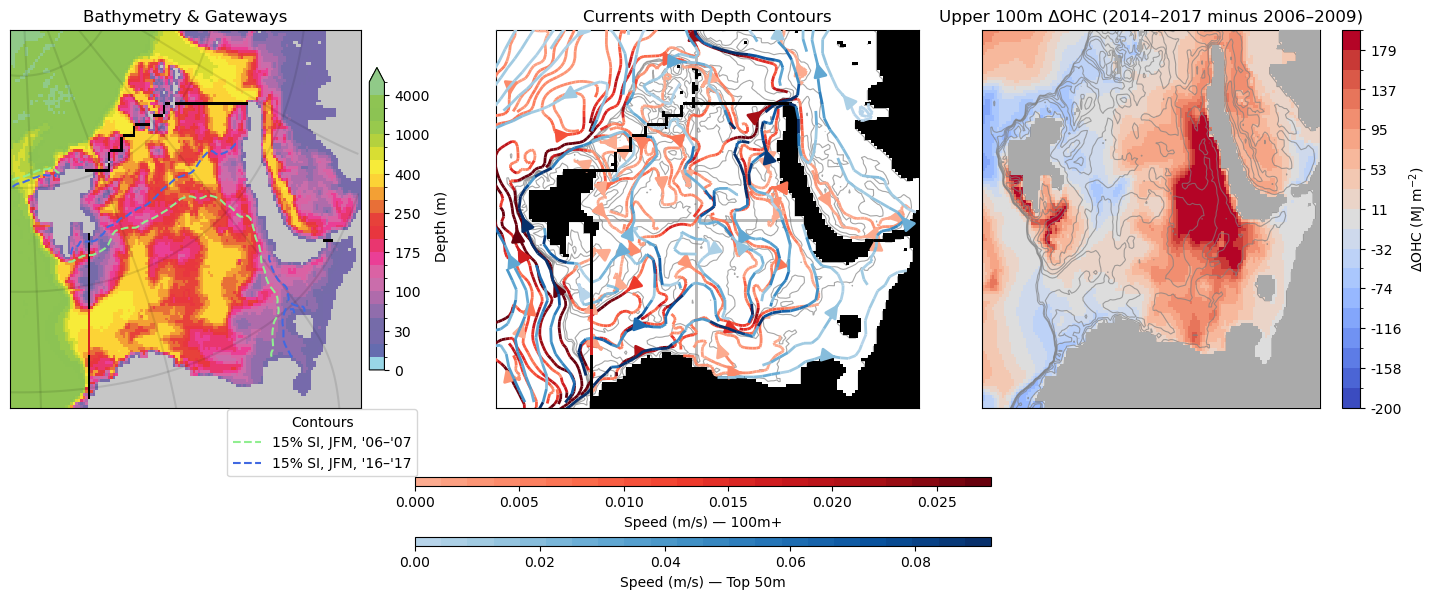

In [113]:

# --- OHC Difference Calculation ---
ohc_diff = get_aste_tracer(heat_content_diff, nfx, nfy)[0]  # (ny, nx)
land_data = get_aste_tracer(landmsk, nfx, nfy)[0]

# --- OHC Colormap Setup ---
ohc_bounds = np.linspace(-200, 200, 20)
ohc_cmap = plt.get_cmap('coolwarm', len(ohc_bounds) - 1)
ohc_norm = BoundaryNorm(boundaries=ohc_bounds, ncolors=ohc_cmap.N)

# --- Bathymetry Colormap ---
colors = ['#7fcce0', '#3f479b', '#544596', '#534694', '#754898', '#9b4696', '#bd4896',
          '#d13b8d', '#e50f7c', '#e4034b', '#e3030e', '#e11108', '#e34b05', '#f18901',
          '#fcc903', '#f5e707', '#cfd600', '#a2c60e', '#7ebc20', '#6fb528', '#72b628', '#74bd6b']
bounds = [0, 10, 20, 30, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
          400, 500, 750, 1000, 1500, 2000, 4000, 6000]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

# --- Figure Setup ---
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.15)

# ========== Panel A: Bathymetry ==========
ax0 = fig.add_subplot(gs[0])
depth_data = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]
pc = ax0.pcolormesh(depth_data, cmap=cmap, norm=norm, alpha=0.8)
ax0.pcolormesh(land_data, cmap="Greys", zorder=2, vmin=0, vmax=6)
ax0.contour(lat, levels=np.arange(70, 90, 5), colors="k", alpha=.1)
ax0.contour(lon, levels=np.arange(10, 80, 20), colors="k", alpha=.1)
ax0.contour(SI_early_tr_masked, levels=[0.15], colors='lightgreen', linewidths=1.5, linestyles='--')
ax0.contour(SI_late_tr_masked, levels=[0.15], colors='royalblue', linewidths=1.5, linestyles='--')

# Plot gateways
black_cmap = ListedColormap(['black'])
ax0.pcolormesh(get_aste_tracer(gates, nfx, nfy)[0], cmap=black_cmap)
ax0.pcolormesh(get_aste_tracer(bit_mask, nfx, nfy)[0], cmap='Reds',zorder=2,vmin=0.5,vmax=1.2)

# Colorbar
cb0 = fig.colorbar(pc, ax=ax0, orientation='vertical', label="Depth (m)", extend="max", shrink=0.8, pad=0.02, boundaries=bounds)

# Formatting
ax0.set_xlim(400, 540)
ax0.set_ylim(430, 560)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title("Bathymetry & Gateways", fontsize=12)

# Legend
legend_elements = [
    Line2D([0], [0], color='lightgreen', linestyle='--', linewidth=1.5, label="15% SI, JFM, '06–'07"),
    Line2D([0], [0], color='royalblue', linestyle='--', linewidth=1.5, label="15% SI, JFM, '16–'17"),
]
ax0.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(.6, -.2), fontsize=10, frameon=True, title='Contours')

# ========== Panel B: Currents ==========
ax1 = fig.add_subplot(gs[1])
contour_data = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]
ax1.contour(contour_data, levels=[1, 100, 200, 300, 400, 500, 600], colors='grey', linewidths=0.8, alpha=0.7)
ax1.pcolormesh(land_data, cmap="Greys", zorder=2, vmin=0, vmax=2)

ny1, nx1 = all_UVEL_avg_lower.shape
x = np.arange(nx1)
y = np.arange(ny1)
speed_full = np.sqrt(all_UVEL_avg_lower**2 + all_VVEL_avg_lower**2)
speed_top = np.sqrt(all_UVEL_avg_upper**2 + all_VVEL_avg_upper**2)

density =  14
strm1 = ax1.streamplot(x, y, all_UVEL_avg_lower, all_VVEL_avg_lower, color=speed_full,
                       cmap=reds_trunc, norm=plt.Normalize(vmin=0, vmax=np.nanpercentile(speed_full, 95)),
                       density=density, linewidth=2, arrowsize=2, zorder=3)
density= 6
strm2 = ax1.streamplot(x, y, all_UVEL_avg_upper, all_VVEL_avg_upper, color=speed_top,
                       cmap=blues_trunc, norm=plt.Normalize(vmin=0, vmax=np.nanpercentile(speed_top, 95)),
                       density=density, linewidth=2, arrowsize=2, zorder=4)

# Overlay masks and cross-sections
black_cmap = ListedColormap(['black'])
ax1.pcolormesh(get_aste_tracer(gates, nfx, nfy)[0], cmap=black_cmap,zorder=5)
ax1.pcolormesh(get_aste_tracer(bit_mask, nfx, nfy)[0], cmap='Reds',vmin=0.5,vmax=1.2,zorder=6)
tmp = sample_cross.copy()
tmp[~np.isnan(tmp)] = 1
ax1.pcolormesh(get_aste_tracer(tmp, nfx, nfy)[0], cmap="Greys", zorder=1, alpha=.3, vmin=-1, vmax=1.2)

# Colorbars for currents
cb1_ax = fig.add_axes([0.35, 0.12, 0.32, 0.015])
cb1 = fig.colorbar(strm1.lines, cax=cb1_ax, orientation='horizontal')
cb1.set_label("Speed (m/s) — 100m+")

cb2_ax = fig.add_axes([0.35, 0.02, 0.32, 0.015])
cb2 = fig.colorbar(strm2.lines, cax=cb2_ax, orientation='horizontal')
cb2.set_label("Speed (m/s) — Top 50m")

# Formatting
ax1.set_xlim(400, 540)
ax1.set_ylim(430, 560)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Currents with Depth Contours", fontsize=12)

# ========== Panel C: OHC Change ==========
ax2 = fig.add_subplot(gs[2])
pc2 = ax2.pcolormesh(ohc_diff, cmap=ohc_cmap, norm=ohc_norm, shading='auto')
ax2.pcolormesh(land_data, zorder=4, cmap="gray_r", vmin=1, vmax=4)
ax2.contour(contour_data, levels=[1, 100, 200, 300, 400, 500, 600], colors='grey', linewidths=0.8, alpha=0.7)

cb = fig.colorbar(pc2, ax=ax2, orientation='vertical', label='ΔOHC (MJ m$^{-2}$)', ticks=ohc_bounds[::2])
cb.ax.set_yticklabels([f'{b:.0f}' for b in ohc_bounds[::2]])

ax2.set_xlim(400, 540)
ax2.set_ylim(420, 540)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Upper 100m ΔOHC (2014–2017 minus 2006–2009)', fontsize=12)

# Layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.savefig("fig1_context_panels.png", dpi=300,bbox_inches = "tight")
plt.show()

# B: time series inflow evolution

In [57]:
# gates and series
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

choose_UV_bso3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_bso,x_bso):
    choose_UV_bso3d[:,i,j] = np.full(nz,choose_UV_bso[idx])
    idx += 1

choose_UV_sfj3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_sfj,x_sfj):
    choose_UV_sfj3d[:,i,j] = np.full(nz,choose_UV_sfj[idx])
    idx += 1

choose_UV_fjnz3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_fjnz,x_fjnz):
    choose_UV_fjnz3d[:,i,j] = np.full(nz,choose_UV_fjnz[idx])
    idx += 1

choose_UV_nzru3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_nzru,x_nzru):
    choose_UV_nzru3d[:,i,j] = np.full(nz,choose_UV_nzru[idx])
    idx += 1

In [143]:
# Define dimensions
num_years = len(allyears[tstart:])  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ","NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Initialize dictionaries with variable-length arrays for each gate
theta_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}
salt_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}

iy = 0  # Counter for year index

for year in allyears[tstart:]:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    THETA_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    SALT_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "state_3d_set1"
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["THETA", "SALT"]]

        read = [int(tsstr[i])]
        THETAi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[0])
        SALTi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[1])

        THETA_all[i, :, :, :] = np.reshape(THETAi, (nz, ny, nx))
        SALT_all[i, :, :, :] = np.reshape(SALTi, (nz, ny, nx))

    

    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices

        # Compute annual averages for each gate
        RAC_gate = np.tile(mygrid['RAC'][np.newaxis,:,:],(nz,1,1))[:,y_idx, x_idx]  # shape (npoints,)
        DRF_gate = DRF3d[:,y_idx,x_idx]
        hfC_gate = hfC[:,y_idx,x_idx]
        volume_gate = RAC_gate * DRF_gate * hfC_gate

        #print(y_idx)
        for depth in range(nz):

            theta_timeseries[gate][iy, :, depth, :] = THETA_all[:, depth, y_idx, x_idx] * volume_gate[depth] 
            salt_timeseries[gate][iy, :, depth, :] = SALT_all[:, depth, y_idx, x_idx] * volume_gate[depth] 

    iy += 1  # Move to the next year


Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [56]:
# Compute distances dynamically for each gate
gate_distances = {}

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_bso, y_bso, choose_UV_bso), 
                                                                (x_sfj, y_sfj, choose_UV_sfj), 
                                                                (x_fjnz, y_fjnz, choose_UV_fjnz),
                                                                (x_nzru, y_nzru, choose_UV_nzru)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

In [58]:
# Define dimensions
num_years = len(allyears[tstart:])  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ", "NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Selection dictionary for horizontal (ADVx_TH) or vertical (ADVy_TH) transport
choose_UV = {"BSO": choose_UV_bso3d, "SFJ": choose_UV_sfj3d, "FJNZ": choose_UV_fjnz3d, "NZRU": choose_UV_nzru3d}

# Initialize dictionary to store heat transport for each gate
heat_transport_timeseries = {
    gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()
}

iy = 0  # Counter for year index

for year in allyears[tstart:]:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    ADVx_TH_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    ADVy_TH_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "budg3d_hflux_set2"
        meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["ADVx_TH", "ADVy_TH"]]

        read = [int(tsstr[i])]
        ADVx_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[0])
        ADVy_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[1])

        ADVx_TH_all[i, :, :, :] = np.reshape(ADVx_THi, (nz, ny, nx))
        ADVy_TH_all[i, :, :, :] = np.reshape(ADVy_THi, (nz, ny, nx))

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        UV_selection = choose_UV[gate]  # Determine whether to use H (ADVx_TH) or V (ADVy_TH)
        
        for depth in range(nz):
            advx_seasonal = myparms["rcp"] * ADVx_TH_all[:, depth, y_idx, x_idx]
            advy_seasonal = myparms["rcp"] * ADVy_TH_all[:, depth, y_idx, x_idx]
            
            # Use np.where() for per-gridpoint selection
            if gate == "BSO":
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", advx_seasonal, -advy_seasonal)
            elif gate == "SFJ":
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_seasonal, -advy_seasonal)
            else:
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_seasonal, -advy_seasonal)

            heat_transport_timeseries[gate][iy, :, depth, :] = adv_selected


    iy += 1  # Move to the next year

Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [115]:
# Define dimensions
num_years = len(allyears[tstart:])  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ", "NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Selection dictionary for horizontal (ADVx_TH) or vertical (ADVy_TH) transport
choose_UV = {"BSO": choose_UV_bso3d, "SFJ": choose_UV_sfj3d, "FJNZ": choose_UV_fjnz3d, "NZRU": choose_UV_nzru3d}

# Initialize dictionary to store heat transport for each gate
vel_timeseries = {
    gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()
}

iy = 0  # Counter for year index

for year in allyears[tstart:]:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    UVELMASS_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    VVELMASS_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "trsp_3d_set1"
        meta_trsp_3d_set1 = parsemeta(dirtrsp + file_name + "." + read_tsstr + ".meta")
        fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["UVELMASS", "VVELMASS"]]

        read = [int(tsstr[i])]
        UVELMASSi, _, _ = rdmds(os.path.join(dirtrsp, file_name), read, returnmeta=True, rec=recs[0])
        VVELMASSi, _, _ = rdmds(os.path.join(dirtrsp, file_name), read, returnmeta=True, rec=recs[1])

        UVELMASS_all[i, :, :, :] = np.reshape(UVELMASSi, (nz, ny, nx))
        VVELMASS_all[i, :, :, :] = np.reshape(VVELMASSi, (nz, ny, nx))


    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        UV_selection = choose_UV[gate]  # Determine whether to use H (ADVx_TH) or V (ADVy_TH)
        
        for depth in range(nz):
            u_seasonal = UVELMASS_all[:, depth, y_idx, x_idx]
            v_seasonal = VVELMASS_all[:, depth, y_idx, x_idx]
            
            # Use np.where() for per-gridpoint selection
            if gate == "BSO":
                vel_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", u_seasonal, -v_seasonal)
            elif gate == "SFJ":
                vel_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -u_seasonal, -v_seasonal)
            else:
                vel_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -u_seasonal, -v_seasonal)

            vel_timeseries[gate][iy, :, depth, :] = vel_selected


    iy += 1  # Move to the next year

Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [144]:
# save all of these to an npy file

data_to_save = {
    "heat_transport_timeseries": heat_transport_timeseries,
    "theta_timeseries": theta_timeseries,
    "salt_timeseries": salt_timeseries,
    "vel_timeseries": vel_timeseries,
}

# Save to a .npy file
np.save("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_fourgates.npy", data_to_save)

# To load later
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_fourgates.npy", allow_pickle=True).item()

# Access the saved dictionaries
heat_transport_timeseries = loaded_data["heat_transport_timeseries"]
theta_timeseries = loaded_data["theta_timeseries"]
salt_timeseries = loaded_data["salt_timeseries"]
vel_timeseries = loaded_data["vel_timeseries"]

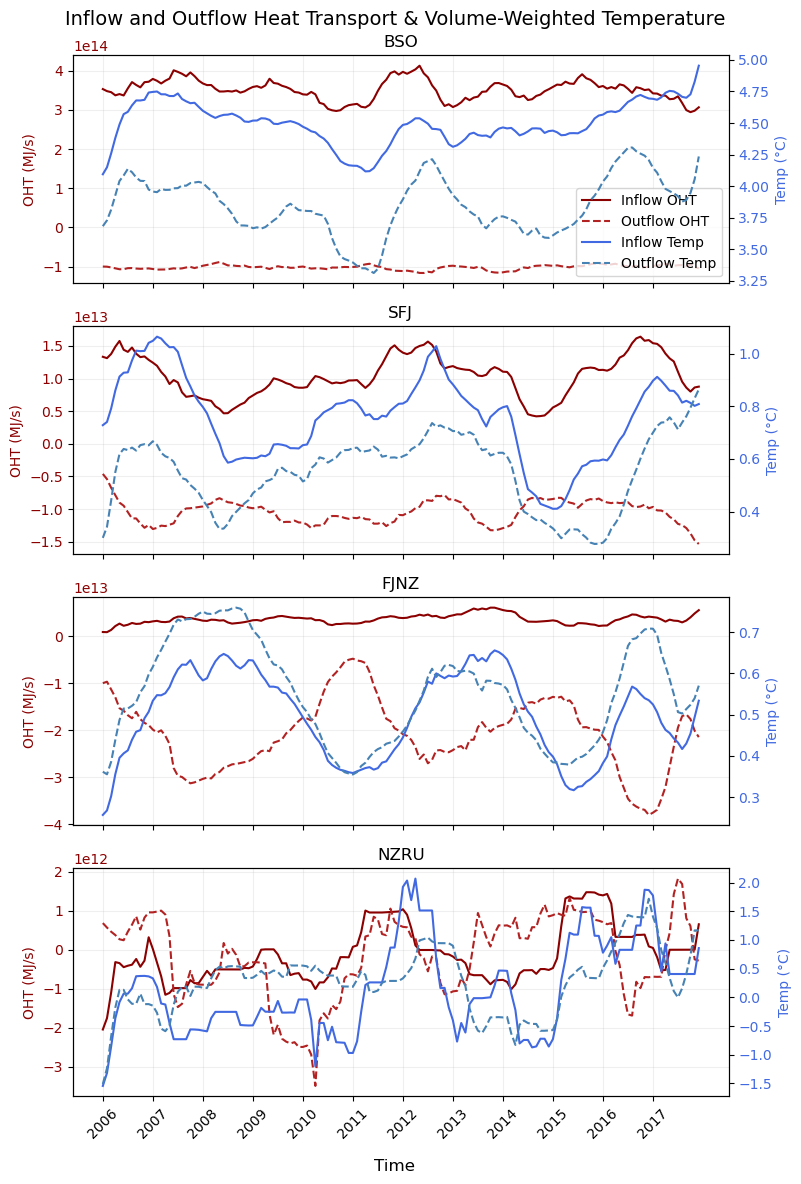

In [146]:
fig, axes = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

xtick_positions = np.arange(0, 12*12, 12)
xtick_labels = np.arange(2006, 2018)
time = np.arange(0, 12*12)
window_size = 12  # months

gates_names = np.array(['BSO', 'SFJ', 'FJNZ', 'NZRU'])

for i, gate in enumerate(gates_names):
    ax1 = axes[i]
    vel = vel_timeseries[gate]  # shape: (years, months, depth, gatepoints)
    theta_volume = theta_timeseries[gate]  # THETA * volume
    Q = heat_transport_timeseries[gate] * myparms['rcp'] * 1e-6  # MJ/s

    # Recreate volume mask (same shape as theta_volume)
    DRF = mygrid['DRF']
    RAC_gate = mygrid['RAC'][gate_indices[gate]]  # shape: (gatepoints,)
    volume_mask = np.zeros_like(theta_volume)

    for k in range(nz):
        volume_mask[:, :, k, :] = DRF[k] * RAC_gate[np.newaxis, :]  # broadcast

    # Create inflow/outflow masks
    inflow_mask = vel > 0
    outflow_mask = vel < 0

    # -------- Volume-weighted Temperature --------
    T_inflow = np.nansum(theta_volume * inflow_mask, axis=(2, 3)) / np.nansum(volume_mask * inflow_mask, axis=(2, 3))
    T_outflow = np.nansum(theta_volume * outflow_mask, axis=(2, 3)) / np.nansum(volume_mask * outflow_mask, axis=(2, 3))

    # -------- Heat Transport --------
    Q_inflow = np.nansum(Q * inflow_mask, axis=(2, 3))
    Q_outflow = np.nansum(Q * outflow_mask, axis=(2, 3))

    # -------- Smoothing --------
    heat_in_smooth = pd.Series(Q_inflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
    heat_out_smooth = pd.Series(Q_outflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
    temp_in_smooth = pd.Series(T_inflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
    temp_out_smooth = pd.Series(T_outflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

    # -------- Plotting --------
    ax1.plot(time, heat_in_smooth, color="darkred", label="Inflow OHT")
    ax1.plot(time, heat_out_smooth, color="firebrick", linestyle="--", label="Outflow OHT")
    ax1.set_ylabel("OHT (MJ/s)", color="darkred")
    ax1.tick_params(axis='y', labelcolor="darkred")
    ax1.set_title(f"{gate}")
    ax1.set_xticks(xtick_positions)
    ax1.set_xticklabels(xtick_labels, rotation=45)
    ax1.grid(alpha=0.2)

    # Twin axis for temperature
    ax2 = ax1.twinx()
    ax2.plot(time, temp_in_smooth, color="royalblue", label="Inflow Temp")
    ax2.plot(time, temp_out_smooth, color="steelblue", linestyle="--", label="Outflow Temp")
    ax2.set_ylabel("Temp (°C)", color="royalblue")
    ax2.tick_params(axis='y', labelcolor="royalblue")

    if i == 0:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

fig.supxlabel("Time")
fig.suptitle("Inflow and Outflow Heat Transport & Volume-Weighted Temperature", fontsize=14)
plt.tight_layout()
plt.savefig("inout_timeseries_weighted_temp.png", dpi=300)
plt.show()


In [135]:
y_bso[19:34]

array([448, 449, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558,
       558, 558], dtype=uint16)

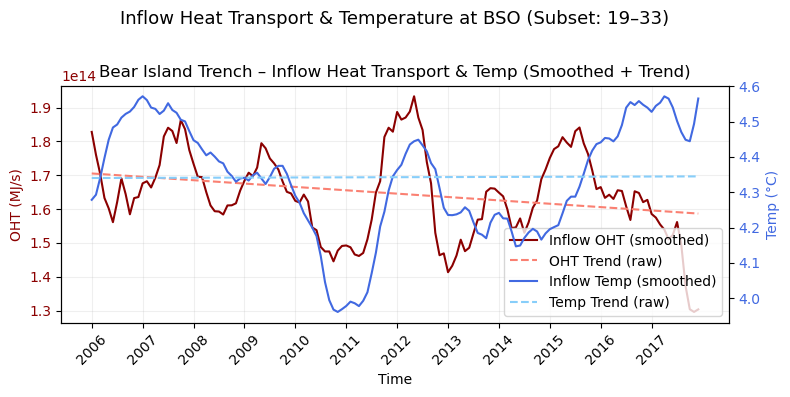

In [171]:
fig, ax1 = plt.subplots(figsize=(8, 4))

xtick_positions = np.arange(0, 12*12, 12)
xtick_labels = np.arange(2006, 2018)
time = np.arange(0, 12*12)
window_size = 12  # months

gate = 'BSO'
gate_slice = slice(19, 34)

# Load data
vel = vel_timeseries[gate][:, :, :, gate_slice]
theta_volume = theta_timeseries[gate][:, :, :, gate_slice]
Q = heat_transport_timeseries[gate][:, :, :, gate_slice] * myparms['rcp'] * 1e-6  # MJ/s

# Volume mask
DRF = mygrid['DRF']
RAC_gate = mygrid['RAC'][gate_indices[gate]][gate_slice]
volume_mask = np.zeros_like(theta_volume)
for k in range(nz):
    volume_mask[:, :, k, :] = DRF[k] * RAC_gate[np.newaxis, :]

# Inflow mask
inflow_mask = vel > 0

# Volume-weighted inflow θ and heat transport (raw)
T_inflow = np.nansum(theta_volume * inflow_mask, axis=(2, 3)) / np.nansum(volume_mask * inflow_mask, axis=(2, 3))
Q_inflow = np.nansum(Q * inflow_mask, axis=(2, 3))

# Flatten for plotting and smooth
T_inflow_flat = T_inflow.flatten()
Q_inflow_flat = Q_inflow.flatten()

temp_in_smooth = pd.Series(T_inflow_flat).rolling(window=window_size, center=True, min_periods=1).mean()
heat_in_smooth = pd.Series(Q_inflow_flat).rolling(window=window_size, center=True, min_periods=1).mean()

# Plot smoothed curves
ax1.plot(time, heat_in_smooth, color="darkred", label="Inflow OHT (smoothed)")
ax1.set_ylabel("OHT (MJ/s)", color="darkred")
ax1.tick_params(axis='y', labelcolor="darkred")
ax1.set_title("Bear Island Trench – Inflow Heat Transport & Temp (Smoothed + Trend)")
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)
ax1.grid(alpha=0.2)

# Linear trend from raw Q
coef_q = np.polyfit(time, Q_inflow_flat, 1)
trend_q = np.poly1d(coef_q)(time)
ax1.plot(time, trend_q, color="salmon", linestyle="--", label="OHT Trend (raw)")

# Temperature on twin axis
ax2 = ax1.twinx()
ax2.plot(time, temp_in_smooth, color="royalblue", label="Inflow Temp (smoothed)")
ax2.set_ylabel("Temp (°C)", color="royalblue")
ax2.tick_params(axis='y', labelcolor="royalblue")

# Linear trend from raw T
coef_t = np.polyfit(time, T_inflow_flat, 1)
trend_t = np.poly1d(coef_t)(time)
ax2.plot(time, trend_t, color="lightskyblue", linestyle="--", label="Temp Trend (raw)")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

# Layout
ax1.set_xlabel("Time")
plt.suptitle("Inflow Heat Transport & Temperature at BSO (Subset: 19–33)", fontsize=13)
plt.tight_layout()
# plt.savefig("figs/BSO_subset_19_34_smoothed_trends.png", dpi=300)
plt.show()


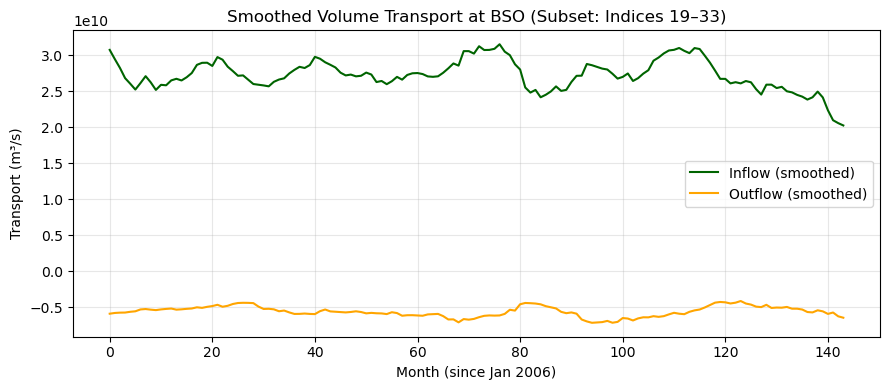

In [173]:
# DRF and RAC already available
vel = vel_timeseries['BSO'][:, :, :, 19:34]  # shape: (years, months, depth, gatepoints)
area = np.zeros_like(vel)

for k in range(nz):
    area[:, :, k, :] = mygrid['DRF'][k] * mygrid['RAC'][gate_indices['BSO']][19:34]

# Compute raw volume transport
volume_transport_in = np.nansum(vel * (vel > 0) * area, axis=(2, 3))  # (years, months)
volume_transport_out = np.nansum(vel * (vel < 0) * area, axis=(2, 3))

# Flatten and smooth
time = np.arange(0, 12 * 12)
window_size = 12  # 12-month rolling window

volume_transport_in_flat = volume_transport_in.flatten()
volume_transport_out_flat = volume_transport_out.flatten()

volume_in_smooth = pd.Series(volume_transport_in_flat).rolling(window=window_size, center=True, min_periods=1).mean()
volume_out_smooth = pd.Series(volume_transport_out_flat).rolling(window=window_size, center=True, min_periods=1).mean()

# Plot
plt.figure(figsize=(9, 4))
plt.plot(time, volume_in_smooth, label="Inflow (smoothed)", color="darkgreen")
plt.plot(time, volume_out_smooth, label="Outflow (smoothed)", color="orange")
plt.title("Smoothed Volume Transport at BSO (Subset: Indices 19–33)")
plt.ylabel("Transport (m³/s)")
plt.xlabel("Month (since Jan 2006)")
# plt.xticks(np.arange(0, 12*12+1, 12), np.arange(2006, 2018))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


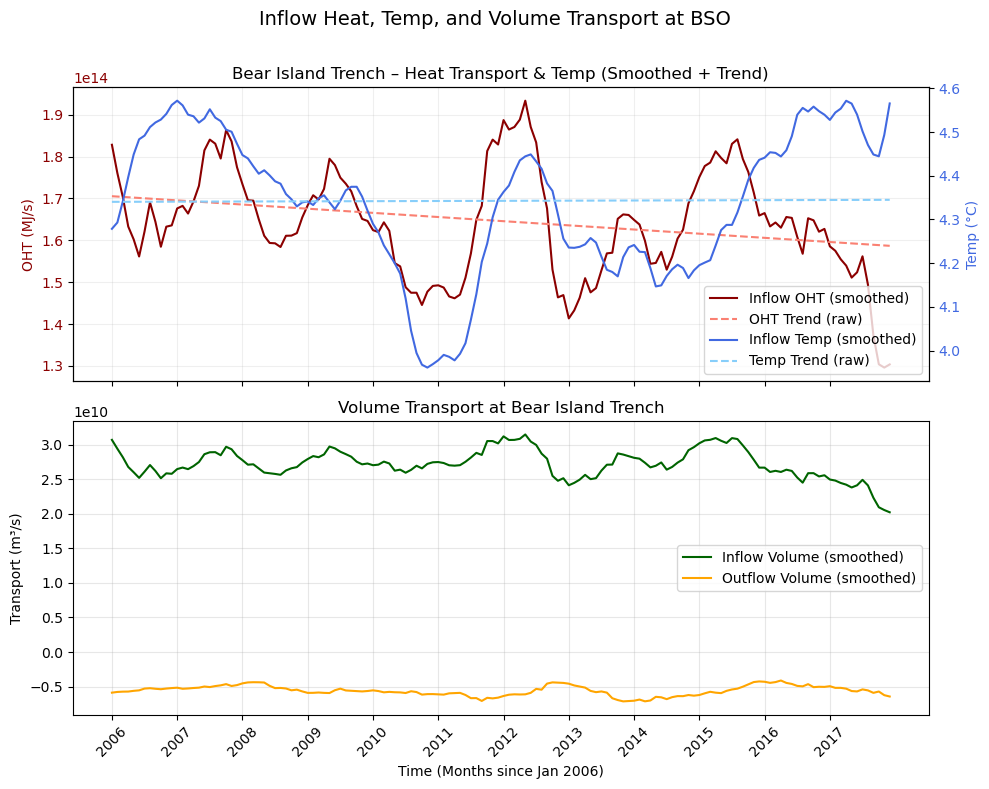

In [175]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

xtick_positions = np.arange(0, 12*12, 12)
xtick_labels = np.arange(2006, 2018)
time = np.arange(0, 12*12)
window_size = 12

gate = 'BSO'
gate_slice = slice(19, 34)

# Load data
vel = vel_timeseries[gate][:, :, :, gate_slice]
theta_volume = theta_timeseries[gate][:, :, :, gate_slice]
Q = heat_transport_timeseries[gate][:, :, :, gate_slice] * myparms['rcp'] * 1e-6  # MJ/s

# Volume mask
DRF = mygrid['DRF']
RAC_gate = mygrid['RAC'][gate_indices[gate]][gate_slice]
volume_mask = np.zeros_like(theta_volume)
area = np.zeros_like(vel)

for k in range(nz):
    volume_mask[:, :, k, :] = DRF[k] * RAC_gate[np.newaxis, :]
    area[:, :, k, :] = DRF[k] * RAC_gate[np.newaxis, :]

# Inflow mask
inflow_mask = vel > 0
outflow_mask = vel < 0

# ----------- Top Plot: Heat Transport and Temp (Smoothed + Trends) -----------
T_inflow = np.nansum(theta_volume * inflow_mask, axis=(2, 3)) / np.nansum(volume_mask * inflow_mask, axis=(2, 3))
Q_inflow = np.nansum(Q * inflow_mask, axis=(2, 3))
T_inflow_flat = T_inflow.flatten()
Q_inflow_flat = Q_inflow.flatten()

temp_in_smooth = pd.Series(T_inflow_flat).rolling(window=window_size, center=True, min_periods=1).mean()
heat_in_smooth = pd.Series(Q_inflow_flat).rolling(window=window_size, center=True, min_periods=1).mean()

# Plot smoothed
ax1.plot(time, heat_in_smooth, color="darkred", label="Inflow OHT (smoothed)")
ax1.set_ylabel("OHT (MJ/s)", color="darkred")
ax1.tick_params(axis='y', labelcolor="darkred")
ax1.set_title("Bear Island Trench – Heat Transport & Temp (Smoothed + Trend)")
ax1.grid(alpha=0.2)

# Trendlines from raw
trend_q = np.poly1d(np.polyfit(time, Q_inflow_flat, 1))(time)
ax1.plot(time, trend_q, color="salmon", linestyle="--", label="OHT Trend (raw)")

ax1b = ax1.twinx()
ax1b.plot(time, temp_in_smooth, color="royalblue", label="Inflow Temp (smoothed)")
ax1b.set_ylabel("Temp (°C)", color="royalblue")
ax1b.tick_params(axis='y', labelcolor="royalblue")
trend_t = np.poly1d(np.polyfit(time, T_inflow_flat, 1))(time)
ax1b.plot(time, trend_t, color="lightskyblue", linestyle="--", label="Temp Trend (raw)")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

# ----------- Bottom Plot: Smoothed Volume Transport -----------
volume_transport_in = np.nansum(vel * inflow_mask * area, axis=(2, 3))
volume_transport_out = np.nansum(vel * outflow_mask * area, axis=(2, 3))

volume_in_smooth = pd.Series(volume_transport_in.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
volume_out_smooth = pd.Series(volume_transport_out.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

ax2.plot(time, volume_in_smooth, label="Inflow Volume (smoothed)", color="darkgreen")
ax2.plot(time, volume_out_smooth, label="Outflow Volume (smoothed)", color="orange")
ax2.set_ylabel("Transport (m³/s)")
ax2.set_xlabel("Time (Months since Jan 2006)")
ax2.set_title("Volume Transport at Bear Island Trench")
ax2.set_xticks(xtick_positions)
ax2.set_xticklabels(xtick_labels, rotation=45)
ax2.legend()
ax2.grid(alpha=0.3)

# Final layout
plt.suptitle("Inflow Heat, Temp, and Volume Transport at BSO", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("BIT_trends.png", dpi=300)
plt.show()


# C: gate cross sections

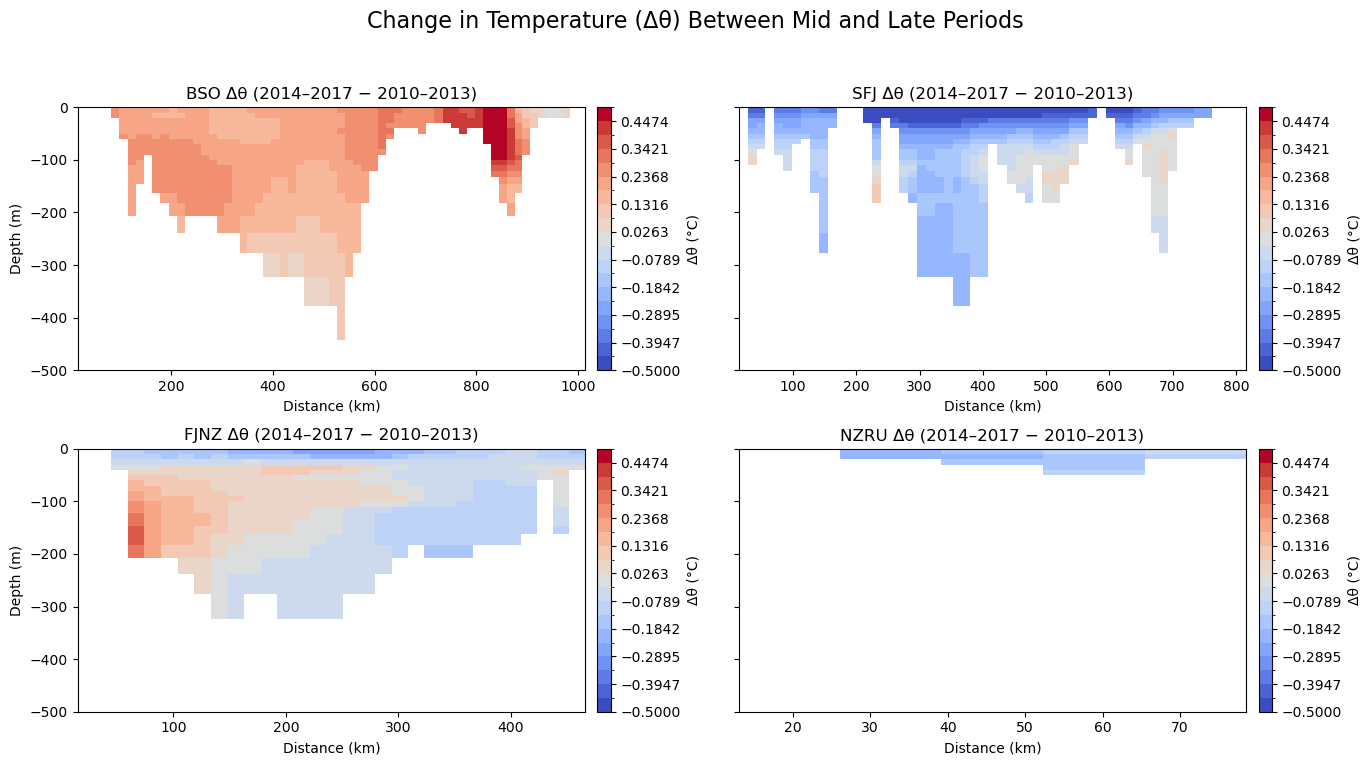

In [192]:
# Time definitions
n_years = len(allyears[tstart:])
early = slice(4, 8)     # first 4 years
late  = slice(-4, None) # last 4 years
n_months = 12
n_time = n_years * n_months

theta_change = {}

for gate in gate_labels:
    # Reshape to (years, months, depth, gatepoints)
    theta_vol = theta_timeseries[gate]  # already θ × volume
    theta_vol_early = theta_vol[early]  # (4, 12, nz, npts)
    theta_vol_late  = theta_vol[late]

    # Volume mask (broadcasted)
    RAC_gate = mygrid['RAC'][gate_indices[gate]]
    volume_mask = np.zeros_like(theta_vol)
    for k in range(nz):
        volume_mask[:, :, k, :] = DRF[k] * RAC_gate[np.newaxis, np.newaxis, :]

    # Average and normalize
    mean_theta_early = np.nanmean(theta_vol_early, axis=(0, 1)) / np.nanmean(volume_mask[early], axis=(0, 1))
    mean_theta_late  = np.nanmean(theta_vol_late, axis=(0, 1)) / np.nanmean(volume_mask[late], axis=(0, 1))

    # Compute difference
    theta_change[gate] = mean_theta_late - mean_theta_early

# Plot settings
theta_diff_bounds = np.linspace(-.5, .5, 20)
theta_cmap = plt.get_cmap('coolwarm')
theta_norm = BoundaryNorm(theta_diff_bounds, ncolors=theta_cmap.N)

# Layout
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
y_vals = np.cumsum(-mygrid['DRF'])  # depth (negative)
x_vals = {gate: gate_distances[gate] for gate in gate_labels}

for idx, gate in enumerate(gate_labels):
    row, col = divmod(idx, 2)
    ax = axes[row, col]

    delta_theta = theta_change[gate]
    X = x_vals[gate]
    Y = y_vals

    # Edges for pcolormesh
    x_edges = np.concatenate([X, [X[-1] + (X[-1] - X[-2])]])
    y_edges = np.concatenate([[0], Y])

    im = ax.pcolormesh(x_edges, y_edges, delta_theta, cmap=theta_cmap, norm=theta_norm, shading='auto')
    ax.set_ylim(-500, 0)
    ax.set_title(f"{gate} Δθ (2014–2017 − 2010–2013)")
    ax.set_xlabel("Distance (km)")
    if col == 0:
        ax.set_ylabel("Depth (m)")

    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label("Δθ (°C)", fontsize=10)

fig.suptitle("Change in Temperature (Δθ) Between Mid and Late Periods", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("gate_theta_change_2x2.png", dpi=300)
plt.show()

# D: N/S density profile or anomaly

In [34]:
# Define dimensions
num_years = len(allyears[tstart:])  # Number of years
gate_labels = ["NS", "EW"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(sample_cross == label) for gate, label in zip(gate_labels, [1, 3])}

# Initialize dictionaries with variable-length arrays for each gate
theta_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}
salt_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}

iy = 0  # Counter for year index

for year in allyears[tstart:]:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    THETA_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    SALT_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "state_3d_set1"
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["THETA", "SALT"]]

        read = [int(tsstr[i])]
        THETAi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[0])
        SALTi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[1])

        THETA_all[i, :, :, :] = np.reshape(THETAi, (nz, ny, nx))
        SALT_all[i, :, :, :] = np.reshape(SALTi, (nz, ny, nx))

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        #print(y_idx)
        for depth in range(nz):
            theta_timeseries[gate][iy, :, depth, :] = THETA_all[:, depth, y_idx, x_idx]
            salt_timeseries[gate][iy, :, depth, :] = SALT_all[:, depth, y_idx, x_idx]

    iy += 1  # Move to the next year


Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [35]:
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])
    return orientations

In [36]:
y_sample,x_sample = np.where(sample_cross == 1)[0], np.where(sample_cross == 1)[1]  # 
y_cross,x_cross = np.where(sample_cross == 3)[0], np.where(sample_cross == 3)[1]

In [37]:
choose_UV_NS = line_orientation(y_sample,x_sample)
choose_UV_EW = line_orientation(y_cross,x_cross)

In [38]:
# Compute distances dynamically for each gate
gate_distances = {}

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_sample, y_sample, choose_UV_NS),
                                                                (x_cross, y_cross, choose_UV_EW)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

In [39]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define symmetric bounds for segmented levels (e.g. anomaly °C)
theta_bounds = np.linspace(-4, 4,  nine_steps := 19)  # 9 segments from -4 to 4
base_cmap = plt.get_cmap('RdBu_r')  # reversed so blue = negative, red = positive
colors = base_cmap(np.linspace(0, 1, nine_steps - 1))

# Create segmented colormap and norm
theta_cmap = ListedColormap(colors)
theta_norm = BoundaryNorm(theta_bounds, ncolors=theta_cmap.N)


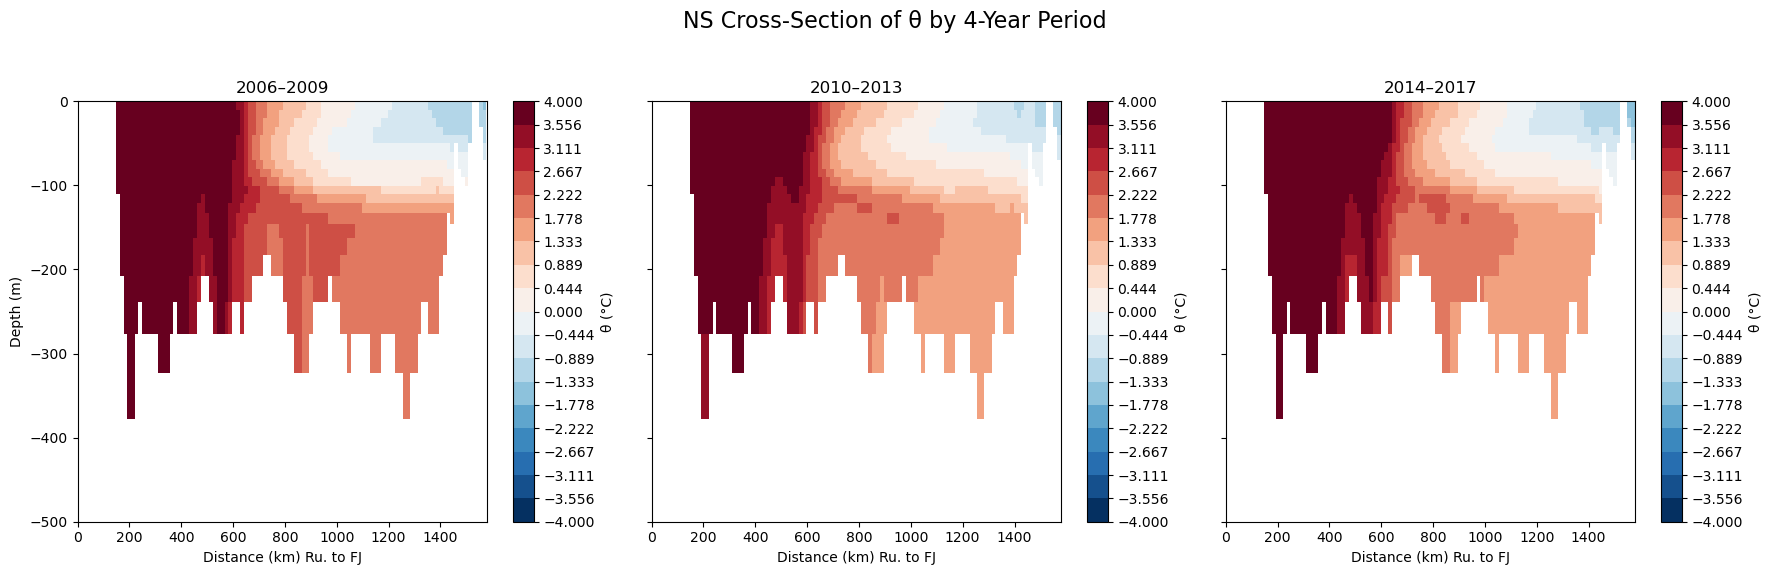

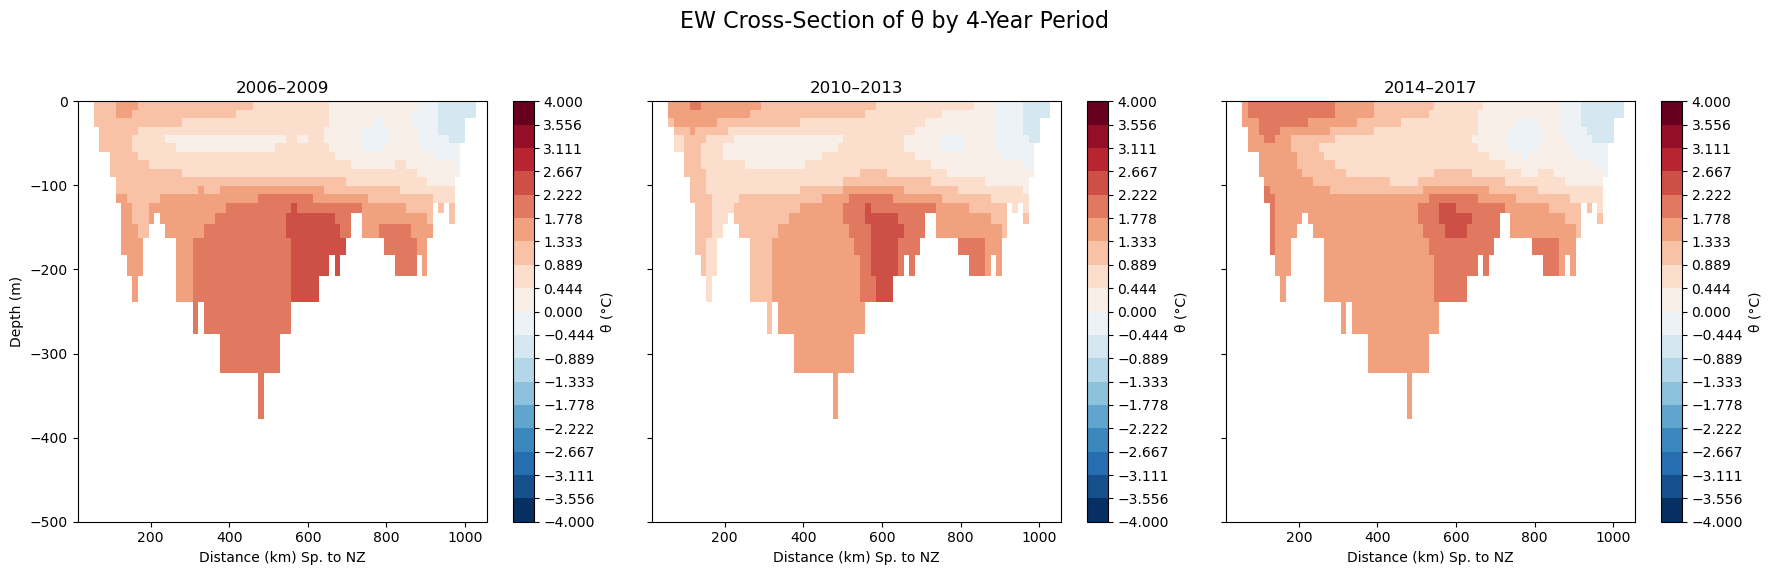

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Year blocks: 2006–2009, 2010–2013, 2014–2017
year_blocks = [(0, 4), (4, 8), (8, 12)]
block_labels = ["2006–2009", "2010–2013", "2014–2017"]

# Depth and gate distances
depth_edges = np.concatenate([[0], np.cumsum(-mygrid['DRF'])])
depth = -np.cumsum(mygrid['DRF'])  # for center values

# Loop over gates to generate one figure per gate
for gate in gate_labels:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle(f"{gate} Cross-Section of θ by 4-Year Period", fontsize=16)

    X_center = gate_distances[gate]
    ngate = X_center.size
    x_edges = np.concatenate([X_center, [X_center[-1] + (X_center[-1] - X_center[-2])]])

    for i, ((start, end), label) in enumerate(zip(year_blocks, block_labels)):
        ax = axes[i]
        theta_data = theta_timeseries[gate]  # shape: (years, 12, nz, length)
        block = theta_data[start:end, :, :, :]  # shape: (4, 12, nz, length)
        theta_avg = np.nanmean(block, axis=(0, 1))  # avg over years and months → shape (nz, length)
        theta_avg[theta_avg == 0] = np.nan  # mask out zeros

        # pcolormesh expects shape (ny, nx) so transpose
        im = ax.pcolormesh(x_edges, depth_edges, theta_avg, cmap=theta_cmap, norm=theta_norm, shading='auto')
        ax.set_title(label)
        ax.set_ylim(-500, 0)
        if gate == "EW":
            ax.set_xlabel("Distance (km) Sp. to NZ")
        elif gate == "NS":
            ax.set_xlabel("Distance (km) Ru. to FJ")
            ax.set_xlim(0,1580)
        if i == 0:
            ax.set_ylabel("Depth (m)")
        fig.colorbar(im, ax=ax, orientation='vertical', label='θ (°C)', ticks=theta_bounds)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"theta_crosssection_{gate}.png", dpi=300)

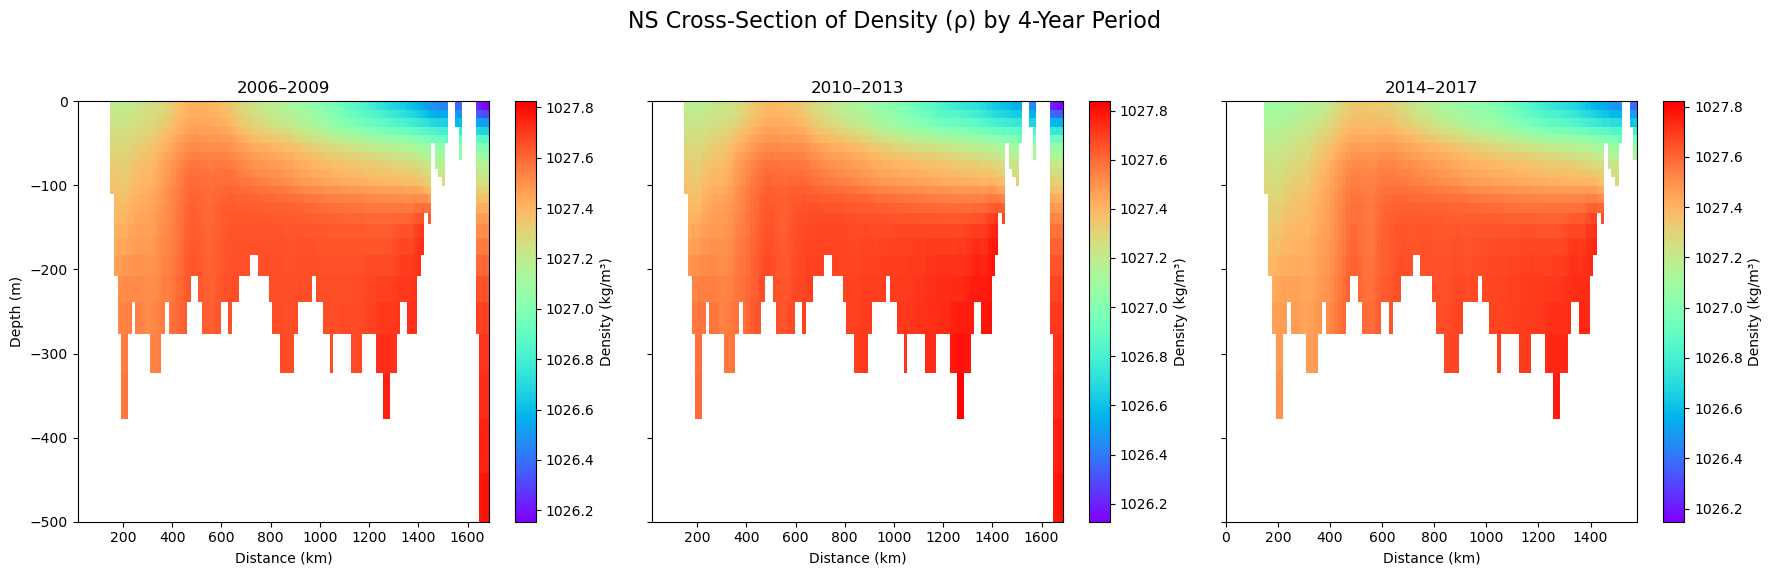

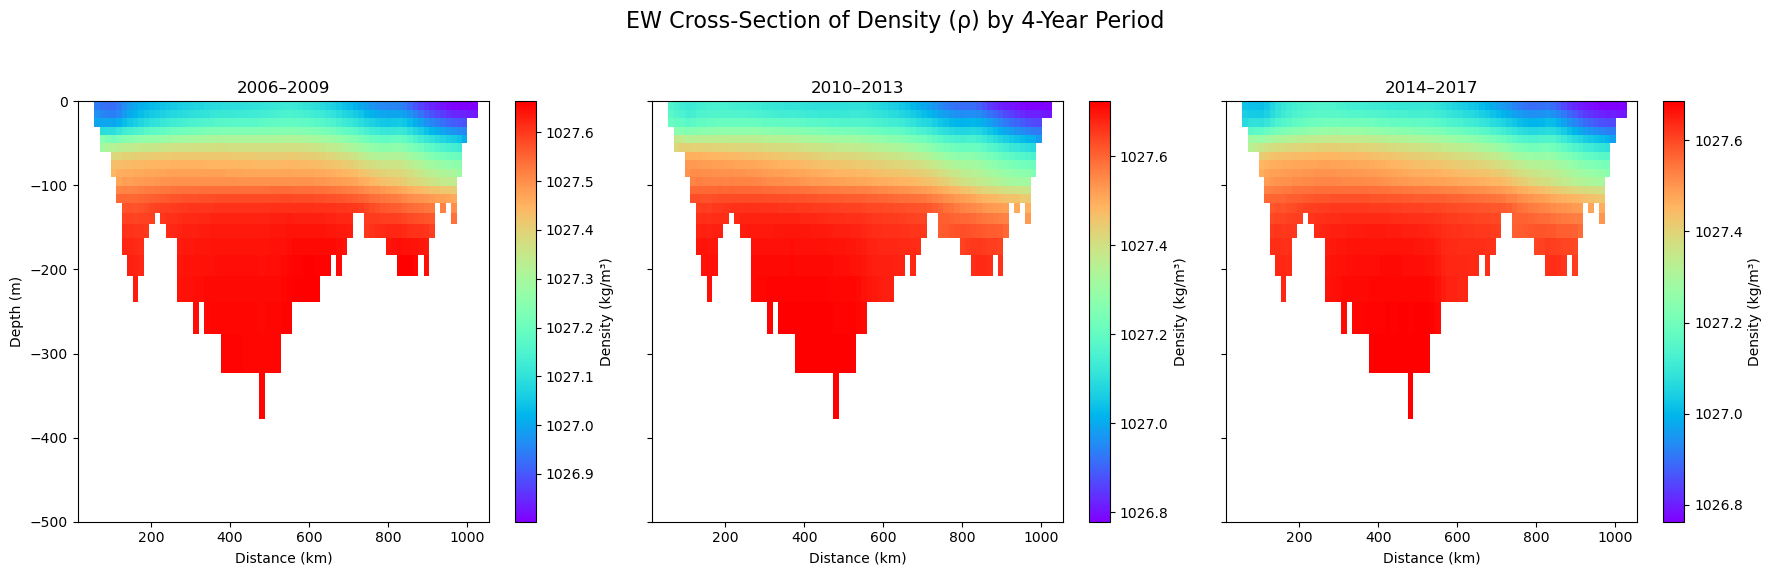

In [61]:
# Define density color bounds (adjust based on your data)
rho_bounds = np.linspace(1026.5, 1028.5, 11)
rho_cmap = plt.get_cmap('viridis')
rho_norm = BoundaryNorm(rho_bounds, ncolors=rho_cmap.N)

# Year blocks and labels
year_blocks = [(0, 4), (4, 8), (8, 12)]
gate_labels
block_labels = ["2006–2009", "2010–2013", "2014–2017"]

# Depth edges for pcolormesh
depth_edges = np.concatenate([[0], np.cumsum(-mygrid['DRF'])])

# Loop over gates
for gate in gate_labels:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle(f"{gate} Cross-Section of Density (ρ) by 4-Year Period", fontsize=16)

    X_center = gate_distances[gate]
    x_edges = np.concatenate([X_center, [X_center[-1] + (X_center[-1] - X_center[-2])]])

    for i, ((start, end), label) in enumerate(zip(year_blocks, block_labels)):
        ax = axes[i]
        theta_data = theta_timeseries[gate]
        salt_data = salt_timeseries[gate]
        rho_data = gsw.rho(salt_data,theta_data,0)
        block = rho_data[start:end, :, :, :]  # select years
        rho_avg = np.nanmean(block, axis=(0, 1))  # mean over years & months → (nz, gatepoints)
        rho_avg[rho_avg == 0] = np.nan  # mask invalids
        rho_avg[rho_avg < 1000] = np.nan

        #im = ax.pcolormesh(x_edges, depth_edges, rho_avg, cmap=rho_cmap, norm=rho_norm, shading='auto')
        im = ax.pcolormesh(x_edges, depth_edges, rho_avg, cmap='rainbow')
        ax.set_title(label)
        ax.set_ylim(-500, 0)
        ax.set_xlabel("Distance (km)")
        if i == 0:
            ax.set_ylabel("Depth (m)")
        fig.colorbar(im, ax=ax, orientation='vertical', label='Density (kg/m³)')
    if gate == "NS":
        ax.set_xlim(0,1580)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"density_crosssection_{gate}.png", dpi=300)
    plt.show()


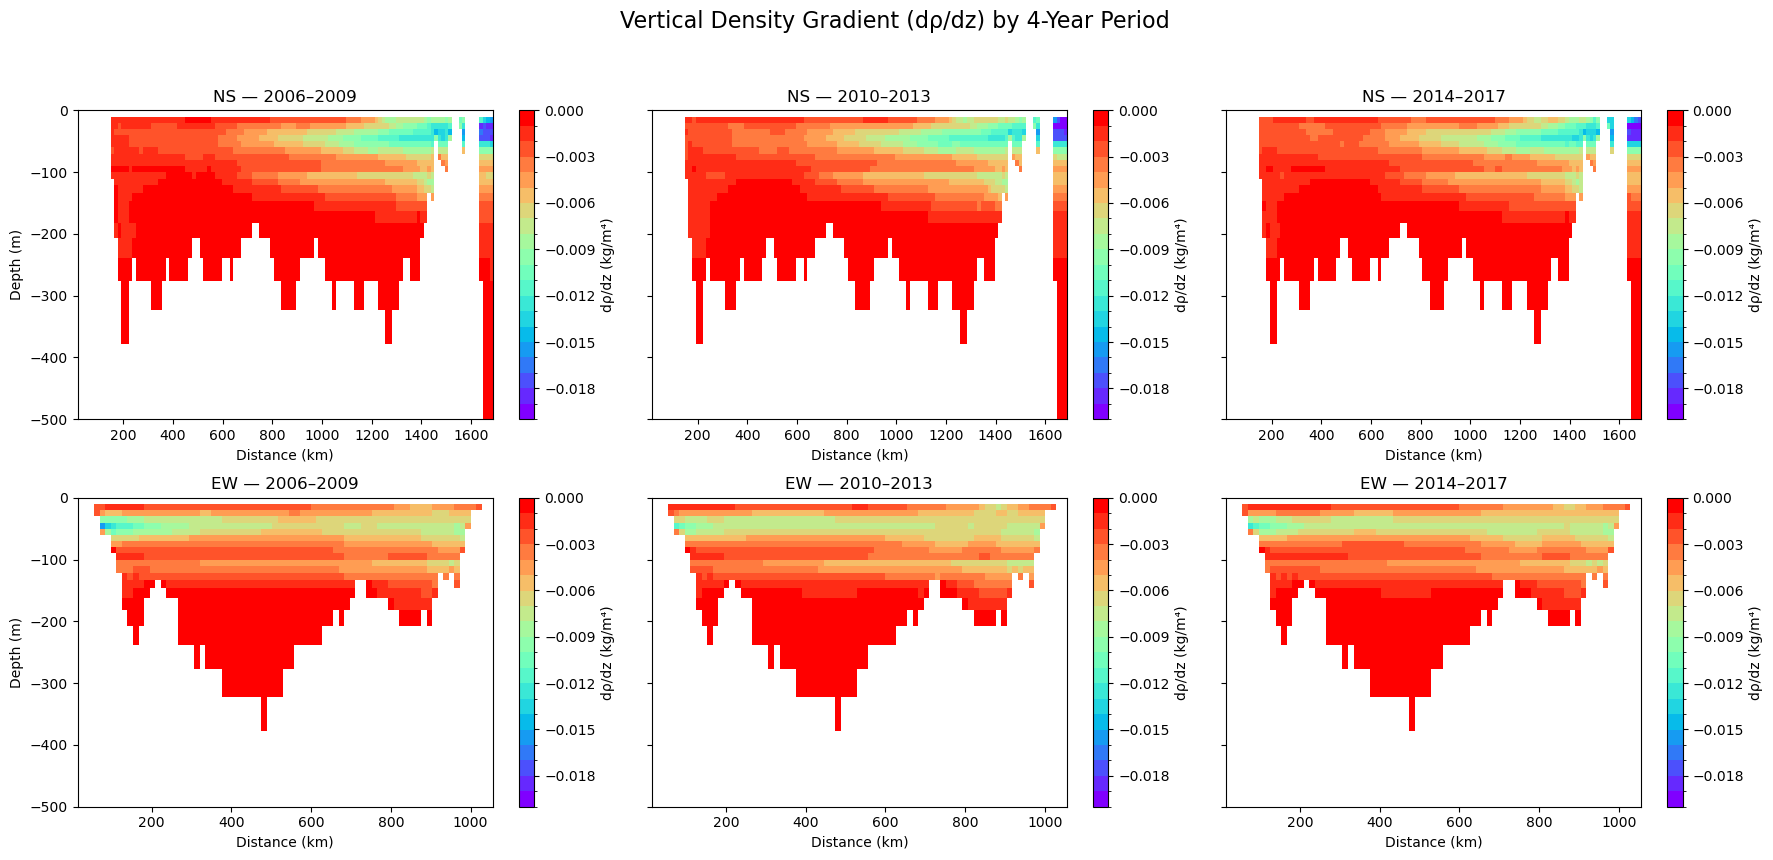

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import gsw

# Settings
gates_to_compare = ["NS", "EW"]
year_blocks = [(0, 4), (4, 8), (8, 12)]
block_labels = ["2006–2009", "2010–2013", "2014–2017"]

# Color bounds for vertical gradient (adjust based on output)
drho_dz_bounds = np.linspace(-0.02, 0, 21)
drho_dz_cmap = plt.get_cmap("rainbow")
drho_dz_norm = BoundaryNorm(drho_dz_bounds, ncolors=drho_dz_cmap.N)

# Depth for center points
z = -np.cumsum(mygrid["DRF"])  # center depth (negative, increasing)
dz = np.diff(np.concatenate(([0], z)))  # dz between layers
depth_edges = np.concatenate([[0], z])  # for pcolormesh

fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharey=True)
fig.suptitle("Vertical Density Gradient (dρ/dz) by 4-Year Period", fontsize=16)

for row, gate in enumerate(gates_to_compare):
    X_center = gate_distances[gate]
    x_edges = np.concatenate([X_center, [X_center[-1] + (X_center[-1] - X_center[-2])]])

    theta_data = theta_timeseries[gate]
    salt_data = salt_timeseries[gate]
    rho_data = gsw.rho(salt_data, theta_data, 0)
    rho_data[rho_data < 1000] = np.nan

    for col, ((start, end), label) in enumerate(zip(year_blocks, block_labels)):
        ax = axes[row, col]

        # Mean density for block
        block = rho_data[start:end, :, :, :]  # (years, months, nz, npts)
        rho_avg = np.nanmean(block, axis=(0, 1))  # (nz, npts)

        # Compute vertical gradient (forward diff)
        drho_dz = np.diff(rho_avg, axis=0) / dz[1:, np.newaxis]  # shape (nz-1, npts)

        # Build pcolormesh grid
        y_edges = depth_edges
        im = ax.pcolormesh(x_edges, y_edges[1:], drho_dz, cmap=drho_dz_cmap, norm=drho_dz_norm, shading="auto")
        ax.set_ylim(-500, 0)
        ax.set_title(f"{gate} — {label}")
        ax.set_xlabel("Distance (km)")
        if col == 0:
            ax.set_ylabel("Depth (m)")
        fig.colorbar(im, ax=ax, orientation='vertical', label="dρ/dz (kg/m⁴)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("density_gradient_crosssection_BSO_SFJ.png", dpi=300)
plt.show()

# E: time series AW thickness and sea ice extent totally

# put the plots together